In [1]:
"""
sudo pip2 install --upgrade opencv-python
sudo pip2 install --upgrade opencv-contrib-python

sudo pip3 install --upgrade opencv-python
sudo pip3 install --upgrade opencv-contrib-python
"""

'\nsudo pip2 install --upgrade opencv-python\nsudo pip2 install --upgrade opencv-contrib-python\n\nsudo pip3 install --upgrade opencv-python\nsudo pip3 install --upgrade opencv-contrib-python\n'

In [2]:
%pylab inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Da aggiornare i nomi delle immagini nella lista "vettore_immagini_lette"

In [4]:
def init_feature(name): #definiamo una feature con varie parametri/famiglie di feature

    detector = None
    norm = None
    matcher = None

    FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
    FLANN_INDEX_LSH = 6
    chunks = name.split('-')
    if chunks[0] == 'sift':
        detector = cv2.xfeatures2d.SIFT_create()
        norm = cv2.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv2.xfeatures2d.SURF_create(800)
        norm = cv2.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv2.ORB_create(400)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv2.AKAZE_create()
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv2.BRISK_create()
        norm = cv2.NORM_HAMMING
    else:
        return None, None


    if 'flann' in chunks:
        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        else:
            flann_params = dict(algorithm=FLANN_INDEX_LSH,
                                table_number=6,  # 12
                                key_size=12,  # 20
                                multi_probe_level=1)  # 2
        matcher = cv2.FlannBasedMatcher(flann_params, {})  # bug : need to pass empty dict (#1329)
    else:
        matcher = cv2.BFMatcher(norm)
    return detector, matcher

In [5]:
#detector_matcher = 'sift-flann'
detector_matcher = 'orb-flann'
#detector_matcher = 'akaze-flann'
#detector_matcher = 'brisk-flann'

In [6]:
detector,matcher = init_feature(detector_matcher)

In [7]:
#####   matching features   ######
# IL CODICE COMINCIA DA QUI

In [8]:
img1 = cv2.imread('ficarra1.jpg')
vettore_immagini_lette=[cv2.imread('ficarra1.jpg'),cv2.imread('Ermal-Meta1.jpeg'),cv2.imread('sosia_1.jpg'),cv2.imread('sosia_2.jpg'),cv2.imread('sosia_3.jpg'),cv2.imread('marcelo.jpg'),cv2.imread('obama1.jpg'),cv2.imread('index.jpg'),cv2.imread('Fic_1.jpg'),cv2.imread('Fic_2.jpg'),cv2.imread('Fic_3.jpg'),cv2.imread('ficarra.jpg'),cv2.imread('gianni-morandi.jpg'),cv2.imread('GIOVANNI-ALLEVI.jpeg'),cv2.imread('marceloHD.jpeg'),cv2.imread('template.jpg')]
imgquery=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
indicelista=0


In [9]:
#img1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
immaginicolor=[]
for i in range(0,len(vettore_immagini_lette)):
    immaginicolor.append(cv2.cvtColor(vettore_immagini_lette[indicelista],cv2.COLOR_BGR2GRAY))



In [10]:

#IMMAGINICOLOR È IL VETTORE CON LA LISTA DI IMMAGINI PER IL TRAIN
#mediante indice lista scorro lungo il vettore delle immagini di train

In [11]:
kp1, desc1 = detector.detectAndCompute(imgquery, None)
kp2, desc2 = detector.detectAndCompute(immaginicolor[indicelista], None)


In [12]:
img1_annotated = np.zeros_like(imgquery)
img2_annotated = np.zeros_like(immaginicolor[indicelista])

In [13]:
img1_annotated = cv2.drawKeypoints(imgquery,kp1,img1_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_annotated = cv2.drawKeypoints(immaginicolor[indicelista],kp2,img2_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [14]:
raw_matches = matcher.knnMatch(desc1, trainDescriptors=desc2, k=2)
#creo un matcher e gli vado a dire "mi devi confrontare questo con questo"

In [15]:
def filter_matches(kp1, kp2, matches, ratio=0.75):

    mkp1, mkp2 = [], []


    m = []

    for m in matches:

        if len(m) == 2 and m[0].distance < m[1].distance * ratio:

            m = m[0]
            mkp1.append(kp1[m.queryIdx])
            mkp2.append(kp2[m.trainIdx])


    #if debug_mode:print("appended keypoints")
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, kp_pairs
#inserisco un filtro

In [16]:
q, a, kp_pairs = filter_matches(kp1, kp2, raw_matches)

In [17]:
H, status = cv2.findHomography(q,a,cv2.RANSAC,5.0)
#homografia 

In [18]:
h1, w1  = imgquery.shape[:2]
h2, w2  = immaginicolor[indicelista].shape[:2]
vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)

In [19]:
vis[:h1, :w1] = imgquery

In [20]:
vis[:h2, w1:w1 + w2] = immaginicolor[indicelista]

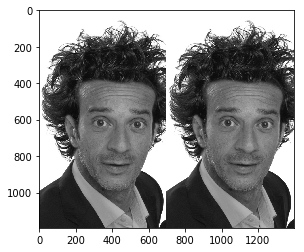

In [21]:
imshow(vis,cmap="gray")

In [22]:
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

In [23]:
green = (0, 255, 0)
red = (0, 0, 255)

In [24]:
p1 = np.int32([kpp[0].pt for kpp in kp_pairs])
p2 = np.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)

In [25]:
corners_starting = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
corners_ending = np.int32(cv2.perspectiveTransform(corners_starting.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0))
vis = cv2.polylines(vis, [corners_ending], True, (255, 0, 0),12)

In [26]:
for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
    if inlier:
        cv2.line(vis, (x1, y1), (x2, y2), green)

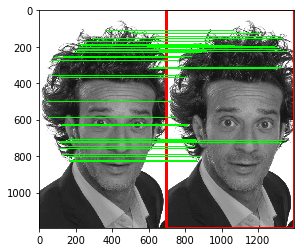

In [27]:
imshow(vis)